# Grid layout optimization

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/regular_grid_optimization.ipynb) (requires google account)


In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

## Import section

In [4]:
import numpy as np
from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site
from py_wake import BastankhahGaussian
from py_wake.utils.gradients import autograd
from topfarm import TopFarmProblem
from topfarm.plotting import XYPlotComp
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients

## Set up site and optimization problem
Grid layout optimization is using the topfarm.reg_x_key and topfarm.reg_y_key which defaults to 'sx' and 'sy' respectively to indicate turbine spacing in x- and y-directions.
The TopfarmProblem has to be instantiated with 'grid_layout_comp=' where you convert spacings into XY-coordinates which enables the use of AEP-components and constraint components as XYBoundary and Spacing components which rely on XY-coordinates. The regular grid functions in topfarm.utils also supports grid rotation, row-staggering and number of rows to number of columns ratio.

In [5]:
site = Hornsrev1Site()
wt = V80()
D = wt.diameter()
windFarmModel = BastankhahGaussian(site, wt)
n_wt = 16
boundary = [[-800,-50], [1200, -50], [1200,2300], [-800, 2300]]
stagger = 1 * D

def reg_func(sx, sy, rotation, **kwargs):
    x, y = regular_generic_layout(n_wt, sx, sy, stagger, rotation)
    return [x, y]

def reg_grad(sx, sy, rotation, **kwargs):
    dx_dsx, dy_dsx, dx_dsy, dy_dsy, dx_dr, dy_dr = regular_generic_layout_gradients(n_wt, sx, sy, stagger, rotation)
    return [[dx_dsx, dy_dsx], [dx_dsy, dy_dsy], [dx_dr, dy_dr]]

reg_grid_comp = CostModelComponent(input_keys=[('sx', 0), 
                                               ('sy', 0),
                                               ('rotation', 0)],
                              n_wt=n_wt,
                              cost_function=reg_func,
                              cost_gradient_function = reg_grad,
                              output_keys= [('x', np.zeros(n_wt)), ('y', np.zeros(n_wt))],
                              objective=False,
                              use_penalty=False,
                              )

def aep_fun(x, y):
    aep = windFarmModel(x, y).aep().sum()
    return aep

daep = windFarmModel.aep_gradients(gradient_method=autograd, wrt_arg=['x', 'y'])
aep_comp = CostModelComponent(input_keys=['x', 'y'],
                              n_wt=n_wt,
                              cost_function=aep_fun,
                              cost_gradient_function = daep,
                              output_keys= ("aep", 0),
                              output_unit="GWh",
                              maximize=True,
                              objective=True)

problem = TopFarmProblem(design_vars={'sx': (3*D, 2*D, 15*D), 
                                      'sy': (4*D, 2*D, 15*D), 
                                       'rotation': (50, 0, 90)
                                      },
                         constraints=[XYBoundaryConstraint(boundary),
                                      SpacingConstraint(4*D)],
                        grid_layout_comp=reg_grid_comp,
                        n_wt = n_wt,
                        cost_comp=aep_comp,
                        driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200),
                        plot_comp=XYPlotComp(),
                        expected_cost=0.1,
                        )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


## Optimize

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


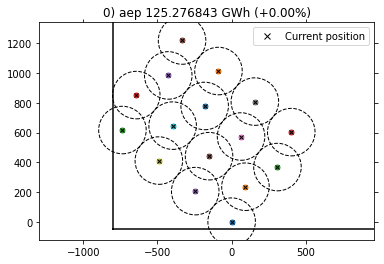

C:\Users\mikf\Anaconda3\envs\om3\lib\site-packages\openmdao\core\total_jac.py:1539: DerivativesWarning:Constraints or objectives [('pre_constraints.xy_bound_comp.boundaryDistances', inds=[(0, 0), (0, 1), (0, 2), (0, 3)])] cannot be impacted by the design variables of the problem.


Optimization terminated successfully    (Exit mode 0)
            Current function value: [-1400.98920343]
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization Complete
-----------------------------------


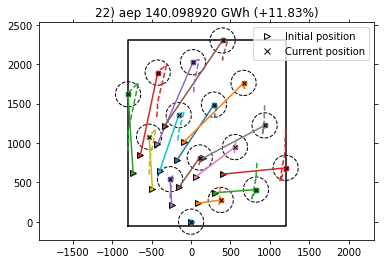

In [6]:
cost, state, recorder = problem.optimize(disp=False)